In [1]:
from nd2reader import ND2Reader
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy import stats as st
from skimage import filters, color, morphology
from skimage.segmentation import watershed, mark_boundaries
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from scipy.ndimage import label
import cv2
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF 

C:\Users\raymo\AppData\Local\Temp\ipykernel_25060\1891274820.py:14: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [2]:
#Ill make it a function
def boxcar(shape,array):
    #boxcar time
    kernel = np.ones([shape,shape]) / shape**2
    #convolve one layer and then make that layer all of the layers
    dim=len(array.shape)
    if dim==3:
        r=np.array(array[:,:,0])
        g=np.array(array[:,:,1])
        b=np.array(array[:,:,2])
        finalR=sp.ndimage.convolve(r,kernel)
        finalG=sp.ndimage.convolve(g,kernel)
        finalB=sp.ndimage.convolve(b,kernel)
        temp=np.array(array)
        temp[:,:,0]=finalR
        temp[:,:,1]=finalG
        temp[:,:,2]=finalB
        return temp
    else:
        data=np.array(array)
        final=sp.ndimage.convolve(data,kernel)
        #now make new array with the convoled data
        return final
def local_binary(arr,box_size,const,show=False):
    #local binary
    threshold = boxcar(box_size,arr) + const
    fin=np.where(arr < threshold, 0, 255)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def blur_sub(arr,box_size,show=False):
    #blur and subtract background
    b=boxcar(box_size,arr)
    fin=sub_img(arr,b)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def sub_img(arr1,arr2):
    #subracting images and dealing with flips
    fir=np.array(arr1,dtype=float)
    sec=np.array(arr2,dtype=float)
    fin=fir-sec
    fin=np.array(np.where(fin<0,0,fin)*(255/fin.max()),dtype=np.uint8)
    return fin
def otsu_binary(arr):
    if len(arr.shape)==2:
        scaled=(arr/arr.max())*255 #needed for filter
        ttemp=np.stack([scaled,scaled,scaled],axis=2)
        t=color.rgb2gray(ttemp)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        return t2
    else:
        scaled=(arr/arr.max())*255 #needed for filter
        t=color.rgb2gray(scaled)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        t3=np.stack([t2,t2,t2],axis=2)
        return t3

def get_connected_components(image):
    # Label the connected components
    labeled_array, num_features = label(image)
    
    # Extract the connected components
    components = []
    for i in range(1, num_features + 1):
        component = (labeled_array == i).astype(int)
        components.append(component)
    
    return labeled_array,components
def get_masked_region(img, mask):
    """
    Obtain the image region corresponding to the mask.
    """
    masked = img * mask
    return masked[mask > 0]

In [ ]:
fin={}
#os.makedirs('comparison')
for file in os.listdir("Fig_8"):
    if '.nd2' not in file:
        continue
    typ='grid' if ('grid' in file) else 'open'
    with ND2Reader(file) as images:
        if ('grid' in file) and ('8' in file) and False:
            g=np.array(images[0])
            g=g[:,0:int(len(g)/2)]
            g=np.nan_to_num(g)
            r=np.array(images[1])
            r=r[:,0:int(len(r)/2)]
            r=np.nan_to_num(r)
            t=np.array(images[2])
            t=t[:,0:int(len(t)/2)]
            t=np.nan_to_num(t)
        else:
            g=np.array(images[0])
            g=np.nan_to_num(g)
            r=np.array(images[1])
            r=np.nan_to_num(r)
            t=np.array(images[2])
            t=np.nan_to_num(t)        
        gf=np.where(g>r,255,0)
        rf=np.where(r>g,255,0)
        b=np.zeros((g.shape))
        dataO=np.stack([rf,gf,b],axis=2)
        data=dataO.copy()
        if typ=='grid':
            #t2=local_binary(t,8,-30)
            ttemp=np.stack([t,t,t],axis=2)
            t=color.rgb2gray(ttemp)
            thres=filters.threshold_otsu(t)
            t2 = np.where(t > thres,1,0)
            t3=np.stack([t2,t2,t2],axis=2)
            data=data*t3
        data=np.rint(data/data.max())
        fin[file[:-4]]=data[:,:,0].sum()/(t3[:,:,0].sum()) if typ=='grid' else data[:,:,0].sum()/(data.shape[0]*data.shape[1])
        #fig,ax=plt.subplots(1,2)
        #ax[0].imshow(dataO)
        #ax[1].imshow(data)
        #ax[0].set_title(file[:-4]+' original')
        #ax[1].set_title(fin[file[:-4]])
        #plt.savefig(f"comparison/{file[:-4]}.png")
        #plt.close('all')

In [4]:
fin={}
box_size=4
#os.makedirs('comparison')
for file in os.listdir():
    if ('.nd2' not in file):
        continue
    typ='grid' if ('grid' in file) else 'open'
    print(file)
    with ND2Reader(file) as images:
        # Determine the last z-level
        num_z_levels = images.sizes['z'] if 'z' in images.sizes else 1
        last_z_level = num_z_levels - 1
        if "grid" in file.lower():
            # Extract the red and green channels using get_frame_2D
            r = images.get_frame_2D(c=1, z=last_z_level)
            g = images.get_frame_2D(c=0, z=last_z_level)
            t = images.get_frame_2D(c=2, z=last_z_level)
            # Normalize and handle NaN values
            r = np.nan_to_num(r)
            g = np.nan_to_num(g)
            dataO=np.zeros((g.shape[0],g.shape[1],3))
            dataO[:,:,0]=(r/r.max())
            dataO[:,:,1]=(g/g.max())
            data=dataO.copy()
            #get blur
            g=boxcar(box_size,g)
            r=boxcar(box_size,r)
            #got the data
            rf=np.where(r>g,255,0)
            gf=np.where(g>r,255,0)
            #set the local binary in data before manipulation
            data[:,:,0]=rf
            data[:,:,1]=gf
            #now we use T channel to get mask
            t2 = otsu_binary(t)
            t3=np.stack([t2,t2,t2],axis=2)
            data=data*t3 #now mask the binerized data
            data=np.rint(data/data.max()) #bring it back to 0's and 1's as we already masked/scaled
            fin[file[:-4]]=data[:,:,0].sum()/(t2.sum())
        else:
            # Extract the red and green channels using get_frame_2D
            r = images.get_frame_2D(c=1, z=last_z_level)
            g = images.get_frame_2D(c=0, z=last_z_level)
            # Normalize and handle NaN values
            r = np.nan_to_num(r)
            g = np.nan_to_num(g)
            dataO=np.zeros((g.shape[0],g.shape[1],3))
            dataO[:,:,0]=(r/r.max())
            dataO[:,:,1]=(g/g.max())
            data=dataO.copy()
            #get blur
            g=boxcar(box_size,g)
            r=boxcar(box_size,r)
            #got the data
            rf=np.where(r>g,255,0)
            gf=np.where(g>r,255,0)
            #set the local binary in data before manipulation
            data[:,:,0]=rf
            data[:,:,1]=gf
            #now we use T channel to get mask
            data=np.rint(data/data.max()) #bring it back to 0's and 1's as we already masked/scaled
            fin[file[:-4]]=data[:,:,0].sum()/(data.shape[0]*data.shape[1])
        #fig,ax=plt.subplots(1,2)
        #ax[0].imshow(dataO)
        #ax[1].imshow(data)
        #ax[0].set_title(file[:-4]+' original')
        #ax[1].set_title(fin[file[:-4]])
        #plt.savefig(f"comparison/{file[:-4]}.png")
        #plt.close('all')

.5(1)open.nd2
.5(3)grid.nd2
.5(4)grid.nd2
.5(5)grid.nd2
.5(6)grid.nd2
.5open.nd2
.6001open.nd2
.6002grid.nd2
.6003grid.nd2
.6004open.nd2
.6005grid.nd2
.6open.nd2
.7001open.nd2
.7002open.nd2
.7003grid.nd2
.7004grid.nd2
.7005grid.nd2
.7open.nd2
.8001.nd2
.8002grid.nd2
.8003grid.nd2
.8004grid.nd2
.8open.nd2
O5002.nd2
O7.nd2
O7001.nd2
O7002.nd2
O8.nd2
O8001.nd2
O8002.nd2


In [5]:
#get x and y data from open and grided
dfope=pd.DataFrame()
dfgri=pd.DataFrame()
for key in fin.keys():
    if key[0]=='.':
        abun=float(key[0:2])
    elif key[0]=='O':
        abun=float(key[1])/10
    elif key[0]=='P':
        abun=float(key[2])/10
    typ='grid' if ('grid' in key) else 'open'
    col=abun
    if typ=='grid':
        try:
            #already exsits
            dfgri.loc[len(dfgri[col].dropna()),col]=fin[key]
        except:
            #create
            dfgri.loc[0,col]=fin[key]
    else:
        try:
            #already exsits
            dfope.loc[len(dfope[col].dropna()),col]=fin[key]
        except:
            #create
            dfope.loc[0,col]=fin[key]

In [6]:
for c in dfgri.columns:
    a=np.array(dfgri[c].dropna())
    b=np.array(dfope[c].dropna())
    print(st.ttest_ind(a=a, b=b, equal_var=True))

Ttest_indResult(statistic=2.3701476443656824, pvalue=0.06394097437868185)
Ttest_indResult(statistic=3.0148132763157536, pvalue=0.03936347244501869)
Ttest_indResult(statistic=-2.165044425520635, pvalue=0.06710624709126077)
Ttest_indResult(statistic=-2.4757392590642193, pvalue=0.04808216025575057)


In [7]:
gri_low=np.array(list(dfgri[.5].dropna())+list(dfgri[.6].dropna()))
gri_hih=np.array(list(dfgri[.7].dropna())+list(dfgri[.8].dropna()))
ope_low=np.array(list(dfope[.5].dropna())+list(dfope[.6].dropna()))
ope_hih=np.array(list(dfope[.7].dropna())+list(dfope[.8].dropna()))

print(st.ttest_ind(a=gri_low, b=ope_low, equal_var=True))
print(st.ttest_ind(a=gri_hih, b=ope_hih, equal_var=True))

Ttest_indResult(statistic=3.924114013466278, pvalue=0.0023759795460065727)
Ttest_indResult(statistic=-1.8306650615657611, pvalue=0.08708882089416792)


In [8]:
k_r='$\kappa_r$'
f_s=r'$\overline{S}_f$'
s_i=r'$S_i$'
p_s='$p_{i,S}$'
w=r'$\widetilde{w}$'

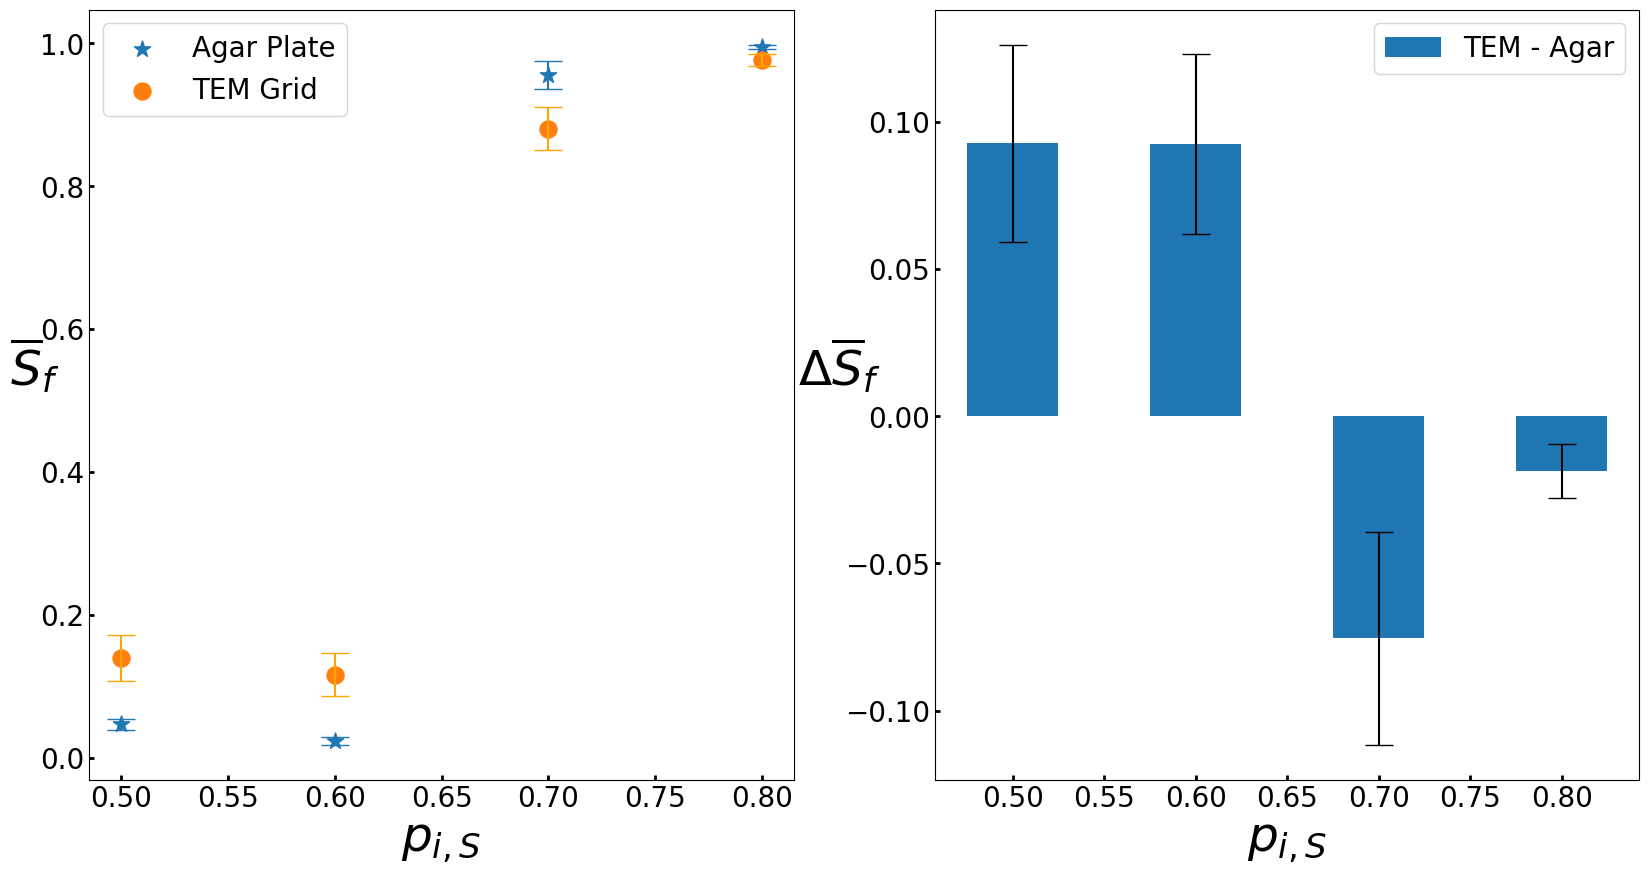

In [9]:
row,col=(1,2)
fig,ax=plt.subplots(row,col,figsize=(col*10,row*10))

opex=np.array(dfope.columns)
opey=np.array(dfope.mean(axis=0))
opeerror=np.array(dfope.std(axis=0))/np.sqrt(np.array(dfope.count()))
grix=np.array(dfgri.columns)
griy=np.array(dfgri.mean(axis=0))
grierror=np.array(dfgri.std(axis=0))/np.sqrt(np.array(dfgri.count()))

line=ax[0].scatter(opex, opey,marker='*',s=150)
line.set_label('Agar Plate')
ax[0].errorbar(opex, opey, yerr=opeerror, fmt='none', capsize=10)

line=ax[0].scatter(grix, griy,marker='o',s=150)
line.set_label('TEM Grid')
ax[0].errorbar(grix, griy, yerr=grierror, fmt='none', capsize=10,color='orange')

ax[0].legend(fontsize=20)
ax[0].set_ylabel(f_s,rotation=0,fontsize=35)
ax[0].set_xlabel(p_s,fontsize=35)
ax[0].tick_params(labelsize=20, direction='in', width=2)


error=np.sqrt(grierror**2 + opeerror**2)
diff=(griy-opey)

#line=ax[1].bar(opex,diff)
#line.set_label('TEM - Agar')
line=ax[1].bar(opex,diff,yerr=error, capsize=10,width=0.05)
line.set_label('TEM - Agar')
ax[1].legend(fontsize=20)
ax[1].set_ylabel(r'$\Delta$'+f_s,rotation=0,fontsize=35)
ax[1].set_xlabel(p_s,fontsize=35)
ax[1].tick_params(labelsize=20, direction='in', width=2)
file='fig8_10_31_23'
#plt.savefig(f'{file}.svg')
#plt.savefig(f'{file}.png')
#drawing = svg2rlg(f"{file}.svg")
#renderPDF.drawToFile(drawing, f"{file}.pdf")